# Facial Keypoints Detection

In this notebook, we build a simpler CNN model using the same architecure as our VGG-15 condensed model which scored high on Kaggle Leaderboard but proved inefficient while training on augmented training datasets. First we define the augmented datasets for our split training sets D1(4 keypoints) and D2(11 keypoints). The simpler CNN model will have the same number of layers to start off with but with smaller filter sizes. We will train several models building on top of it. We will try to vary some of the hyperparamaters like activation functio used, stacked convolutional layers and another mix of augmented data. Performance of each of the models will be checked based on RMSE, Accuracy, Test Predictions and Kaggle Submission Scoring. 

In [1]:
import pandas as pd
import numpy as np
import sys, os, re, time, warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter
from math import sin,cos,pi
from skimage import exposure
from matplotlib import pyplot as plt
%matplotlib inline

# Set seed
np.random.seed(533)

In [2]:
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
from tensorflow import keras as keras
from keras import models, callbacks
from keras import Sequential, Model
from keras import optimizers, metrics
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import utils
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Concatenate
from keras.layers import Embedding

#tf.test.gpu_device_name()
print("tensorflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))
print("python version{}".format(sys.version))

Using TensorFlow backend.


tensorflow version 2.1.0
keras version 2.2.4-tf
python version3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


### Kaggle Setup 

In [ ]:
#Set some directories.
train_zip_path = '/kaggle/input/facial-keypoints-detection/training.zip'
test_zip_path = '/kaggle/input/facial-keypoints-detection/test.zip'
Id_table_path = '/kaggle/input/facial-keypoints-detection/IdLookupTable.csv'
sample_sub_path = '/kaggle/input/facial-keypoints-detection/SampleSubmission.csv'
extracted_files_path = '/kaggle/working'

In [ ]:
#Unzip train csv file to 'extracted_files_path'.
import zipfile
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)
#Unzip test csv file to 'extracted_files_path'.
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

In [ ]:
# train and test datasets file paths
FTRAIN = extracted_files_path + '/training.csv'
FTEST = extracted_files_path + '/test.csv'
FLOOKUP = Id_table_path

In [ ]:
# Load the Kaggle data
print("Loading dataset..")
train = pd.read_csv(FTRAIN)
test = pd.read_csv(FTEST)
lookup = pd.read_csv(FLOOKUP)

### Other Env. Setup

Execute the steps for other environments.

In [3]:
# Input data file paths
FTRAIN = '../../../../data/training/training.csv'
FTEST = '../../../../data/test/test.csv'
FLOOKUP = '../../../../data/IdLookupTable.csv'

In [3]:
# Floyd Hub
# Input data file paths
FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

In [4]:
# Load the Kaggle data
print("Loading dataset..")
train = pd.read_csv(os.path.expanduser(FTRAIN))
test = pd.read_csv(os.path.expanduser(FTEST))
# Load the lookup file
lookup = pd.read_csv(os.path.expanduser(FLOOKUP))

Loading dataset..


### Helper functions


In [72]:
# Function to load the dataset into numpy arrays
def load_dataset(test = False, drop_bad_data = True):
    
    filename = FTEST if test else FTRAIN
    
    print("Loading Data...")
    
    # Read the data into a pandas dataframe
    df = pd.read_csv(os.path.expanduser(filename))

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if not test:
        # Apply only on train data
        
        # Drop any bad data
        if drop_bad_data:
            bad_image_indices = [1877, 1907, 2199]
            cnt = 0
            for index in bad_image_indices:
                df = df.drop(df.index[index - 1 - cnt])
                cnt += 1
            # Drop rows with missing data
            df = df.dropna()
            
    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.
    
    if not test:
        # Apply only on train data
        
        # Extract the labels(x, y coordinates of facial key points) from train data
        y = df[df.columns[:-1]].values
    
        # data with missing labels will be removed from train data
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
     
    else:
        y = None
        
    X = X.reshape(-1, 96, 96, 1)
    X = X.astype(np.float32)

    # Return the train/test data and labels(only for train data)
    return X, y


# function to plot an image - NOT USED
def plot_image(x, y, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=20, c='red')

# function to plot an image - NOT USED
def plot_image_2(image, y, axis):
    # Reshape input into a matrix of pixels
    #img = x.reshape(96, 96)
    #img = x
    
    # Plot the pixels on gray scale
    axis.imshow(image, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='x', s=20, c='red')
    
# function to plot an image with train and predicted keypoints - NOT USED
def plot_predict(x, y, y_predict, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='o', s=20, c='red')
    axis.scatter(y_predict[0::2], y_predict[1::2], marker='o', s=20, c='yellow')
    
# function to get original kaggle train data - NOT USED
def get_orig_train_data():
    
    # Get the location of the train dataset
    fname = FTRAIN
    
    print("Loading data...")
    
    # Read data into pandas dataframe
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays 
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.  
    X = X.astype(np.float32)
    
    # Extract the labels(x, y coordinates of facial key points) from train data
    y = df[df.columns[:-1]].values
    
    # Scale the labels which are x,y coordinates of the facial key points to be between -1 and 1
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    
    # Reshape the images
    X = X.reshape(-1, 1, 96, 96)

    return X, y  

# Function to plot predictions and generate kaggle submission file
def test_predict(model, model_name, keypoints = []):
    
    # split out image values from Kaggle test data
    image = []
    for i in range(test.shape[0]):
        img = test['Image'][i].split(' ')
        img = ['0' if j == '' else j for j in img]
        image.append(img)
    
    # Reshape for prediction
    X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
    X_test.shape
    
    # predict on test data
    Y_test = model.predict(X_test)
    
    # Plot - Test Later
    #fig = plt.figure(figsize=(20, 20))
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
   # for i in range(16):
   #     ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    #    img = X_test[i].reshape(96, 96)
    #    ax.imshow(img, cmap='gray')
    #    ax.scatter(Y_test[i, keypoints], Y_test[i, keypoints], marker='o', color = 'red', s=50, label = 'predict')
        
    #plt.show()
    
    return Y_test

# This generates a .csv file with predictions from Kaggle test data
# The generated .csv file is then submitted on Kaggle to get scores
def generate_submission(Y_test, model_name):
    # Generate submission file
    sub1_df = pd.DataFrame(Y_test, columns=train.columns[:-1])
    sub2_df = pd.concat([test['ImageId'], sub1_df], axis=1)
    sub3_df = pd.melt(sub2_df, id_vars=['ImageId'], value_vars=train.columns[:-1]).rename \
            (columns={"variable": "FeatureName", "value": "Location"})
    sub4_df = pd.merge(lookup.drop(columns=['Location']), sub3_df, on=['ImageId','FeatureName'], how='left')
    sub_final_df = sub4_df[['RowId', 'Location']]

    print(sub_final_df.shape)
    sub_final_df.head()
    # Save the file
    sub_final_df.to_csv(model_name+'.csv', index=False)

# This function is used to plot metrics of trained models
# The metrics used here are RMSE(train data) and Val RMSE(validation)
# It has an option to print the accuracy as well if accuracy = True
def plot_metrics(model_name, history, accuracy = True):
    # plot metrics
    plt.plot(history.history['rmse'], label = 'Train')
    plt.plot(history.history['val_rmse'], label = 'Val')
    plt.legend(loc="best")
    plt.xlabel("epochs")
    plt.ylabel("rmse")
    plt.title(model_name+': RMSE vs. Epoch')
    plt.show()
    
    plt.plot(history.history['loss'], label = 'Train')
    plt.plot(history.history['val_loss'], label = 'Val')
    plt.legend(loc="best")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title(model_name+': Loss vs. Epoch')
    plt.show()

    print('Val RMSE: {}'.format(min(history.history.get('val_rmse'))))
    print('Train RMSE: {} '.format(min(history.history.get('rmse'))))
    if accuracy == True:
        print('Val Accuracy: {}'.format(max(history.history.get('val_accuracy'))))
        print('Train Accuracy: {} '.format(max(history.history.get('accuracy'))))

# Function to plot the loss for a trained model
def plot_loss(hist, model_name):
    plt.plot(hist['loss'], label = model_name)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    
    

In [6]:
# Data Transformation Functions

#=========== ROTATION ================================================================================

# Based on the index of the image in the dataset, the direction of degree of rotation will be done.
# For even numbered indices, the images and keypoints will use +degree rotation.
# For odd numbered indices, the images and keypoints will use -degree rotation.
# This way the augmented dataset will have images rotated in both directions.

# Rotate images at given 'degree' angle
def rotate_images(images, degree, flag):
    
    # create an array for rotated images
    rotated_images = np.zeros((images.shape), dtype=np.float32)
    
    # For each image rotate at angle of given degree 
    # Need to keep the limit between the pixel limits
    for i in range(rotated_images.shape[0]):
        # For even numbered indexes, keep the input degree
        # For odd numbered indexes, use - degree
        if i%2 == 0:
            angle = degree
        else:
            angle = -degree
        
        if flag == True:
            rotated_images[i] = np.clip(rotate(images[i], angle, reshape=False, \
                                               mode='constant'), 0, 1)  
        else:
            rotated_images[i] = np.clip(rotate(images[i], angle, \
                                               mode='constant', cval=150).reshape(96*96), 0, 1)  
                                        
    return rotated_images
        
    
# Rotate the facial keypoint coordinates at given degree angle
def rotate_keypoints(keypoints, degree, n_points):
    
    # create an array for rotated keypoint coordinates
    rotated_keypoints = np.zeros((keypoints.shape), dtype=np.float32)
    
    # define rotation angle and center of rotation
    #theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    # Loop through each keypoint and do rotation
    for i in range(rotated_keypoints.shape[0]):
        # For even numbered indexes, keep the input degree
        # For odd numbered indexes, use - degree
        if i%2 == 0:
            theta = np.radians(degree)
        else:
            theta = np.radians(-degree)
            
        # obtain x and y coordinates from dataset
        x = keypoints[i][np.arange(0, n_points-1, 2)]
        y = keypoints[i][np.arange(1, n_points, 2)]

        # use rotation matrix to rotate coordinates around center
        new_x = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        new_y = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        rotated_keypoints[i] = np.vstack((new_x, new_y)).transpose().flatten()
        
    return rotated_keypoints

#=========== HISTOGRAM EQUALIZATION =====================================================================

# This function uses equalize_hist function under exposure module of skimage.
# Only the images are transformed, the keypoints will be same.
def histogram_eq(images, flag):
    
    # Apply Histogram Equalization to an image
    def image_histogram_eq(image):
        orig_image = image.reshape(96, 96)
        hist_eq_image = exposure.equalize_hist(orig_image)
    
        return hist_eq_image
    
    images_eq = images.copy()
    for index in range(0, len(images)):
        if flag == True:
            images_eq[index] = image_histogram_eq(images[index]).reshape(96, 96, 1)
        else:
            images_eq[index] = image_histogram_eq(images[index]).reshape(-1, (96*96)) 
        
    return images_eq


#=========== BLURRING ====================================================================================

# Apply Blurring using Gaussian Filter to the train data images with sigma = 1.
# The keypoints are not transformed.
def gaussion_blur(images):
    
    images_blur = images.copy()
    
    for index in range(0, len(images)):
        images_blur[index] = gaussian_filter(images[index], sigma = 1).reshape(96, 96, 1)
        
    return images_blur

In [7]:
# Model Helpers

# This function takes 2 models each for the split datasets and makes predictions on test/validation data and
# plots the results
def model_predict(model_d1, model_d2, Xval, Yval, index, d1_label_indices, d2_label_indices, title):
    # Get model predictions
    y_d1 = model_d1.predict(Xval[index].reshape(-1, 96, 96, 1))
    y_d2 = model_d2.predict(Xval[index].reshape(-1, 96, 96, 1))
    
    # Combine both results
    y_comb = np.zeros((1, 30), dtype = np.float32)
    y_comb[:, d1_label_indices] = y_d1
    y_comb[:, d2_label_indices] = y_d2
    
    # Plot
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    img = Xval[index].reshape(96, 96)
    ax.set_title(title)
    ax.imshow(img, cmap='gray')
    ax.scatter(Yval[index][range(0,30,2)], Yval[index][range(1,30,2)], marker='o', s = 20, color='b')
    ax.scatter(y_comb[0][range(0,30,2)], y_comb[0][range(1,30,2)], marker='o', s = 20, color='r')

    plt.show()
    
# This function creates Simple_CNN_Aug model to test data augmentation techniques
# It takes train X, Y and val X, Y with batch size, number of epochs
def train_simple_cnn(Xtrain, Ytrain, Xval, Yval, points, model_code, model_name, simple_models_history_pd, batch_size, epochs):
    
    # Call function Simple_CNN_Aug to create model using the 'points'(keypoints) to train
    model = Simple_CNN_Aug(points)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'accuracy'])
    
    # Train the model
    train_history = model.fit(Xtrain, Ytrain, epochs=epochs, shuffle=False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (Xval, Yval), \
                              callbacks=[early_stop], verbose=2)
    
    # Call function to plot metrics of results
    plot_metrics(model_name, train_history, True)

    # Append history to pd 
    hist = pd.DataFrame(train_history.history)
    hist['Model_Name'] = model_name
    hist['Model_Code'] = model_code
    hist['Val_RMSE'] = min(hist.val_rmse)
    hist['RMSE'] = min(hist.rmse)
    simple_models_history_pd = pd.concat([simple_models_history_pd, hist])
    
    return model

def train_vgg16_2(Xtrain, Ytrain, Xval, Yval, points, model_code, model_name, cnn_models_history_pd, batch_size, epochs):
    
    print("====== " + model_name + " ======= \n")
    model = VGG_16_2(points)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'accuracy'])
    
    train_history = model.fit(Xtrain, Ytrain, epochs=epochs, shuffle=False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (Xval, Yval), \
                              callbacks=[early_stop, reduce_lr], verbose=2)
    
    # Call function to plot metrics of results
    plot_metrics(model_name, train_history, True)

    hist = pd.DataFrame(train_history.history)
    hist['Model_Name'] = model_name
    hist['Model_Code'] = model_code
    hist['Val_RMSE'] = min(hist.val_rmse)
    hist['RMSE'] = min(hist.rmse)
    cnn_models_history_pd = pd.append([simple_models_history_pd, hist])
    
    return model

## Dataset

- The input images are 96x96 pixels in the range from 0 - 255.
- The following 15 keypoints, represented in (x,y) coordinates, should be predicted. They are in the range of 0-96.

  left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip
  
  

- 7049 training images and 1783 testing images 

#### Load and pre-process the Kaggle test data
The kaggle test data has only the input images for which we have to predict the keypoint labels. The pixel values for the images are normalized to be between 0 and 1 consistent with our pre-processed train data above.

In [59]:
# Load the pre-processed test data 
test_data, _ = load_dataset(test = True)
print("Test Images: " + str(test_data.shape))

# Reshape for prediction
X_test_kaggle = test_data
X_test_kaggle.shape

Loading Data...
Test Images: (1783, 96, 96, 1)


(1783, 96, 96, 1)

## Data Transformation and Augmentation of Final Split Datasets

In the previous stage, several data transformation techiniques and combinations on the train data and augmenting the transformations to train data helped expand our dataset with more samples and variance. The augmentation was evaluated on a Simple CNN Architecture with 3 convolution layers, 1 dense layer and 1 layer for output. The best performance based on Validation RMSE was when trained with augmented datasets by applying **Rotation at 10 degrees** for images and keypoints, **Histogram Equalization** of pixel values of images and **Blurring** the Images using Gaussian Filter.  With this success, we applied the same augmentation on our earlier tested VGG-16 inspired model which was the best out of the initial models tested based on classic CNN architectures like LeNet-5, AlexNet and ofcourse VGG-16. Well, the performance of the model was disappointing as it performed very slow due to the larger augmented datasets(train data tripled in size). 

So it was decided to revise the architecture to make it simpler and more efficient in terms of training time and performance. 

#### Define Master Dataset

This set will not have any rows with missing values removed. It will use the entire 7049 images and keypoints co-ordinates.

In [8]:
# Now split the Kaggle training dataset into input images and keypoints labels

# First shuffle the Kaggle training data
np.random.seed(533)
shuffle = np.random.permutation(np.arange(train.shape[0]))
train_shuff = train.iloc[shuffle].reset_index(drop=True)

print("Loading data...")
# Split out image values
images = []
for i in range(train_shuff.shape[0]):
    img = train_shuff['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    images.append(img) 

# Assign to np array
X_train_master = np.array(images, dtype = 'float64')
print(X_train_master.shape)

# Get the keypoint labels
labels = train_shuff.drop('Image', axis = 1)
Y_train_master = np.array(labels, dtype = 'float64')
print(Y_train_master.shape)

Loading data...
(7049, 9216)
(7049, 30)


In [98]:
# Optional: Load from saved arrays
X_train_orig = np.load('X_train_master.npy')
Y_train_orig = np.load('Y_train_master.npy')
print(X_train_orig.shape, Y_train_orig.shape)

In [9]:
# Make a copy so as not to change the master
X_train_orig = np.copy(X_train_master)
Y_train_orig = np.copy(Y_train_master)
print(X_train_orig.shape, Y_train_orig.shape)

(7049, 9216) (7049, 30)


In [10]:
# Normalize the pixel values to be between (0, 1)
X_train_orig = X_train_orig/255.
print(X_train_orig.shape, Y_train_orig.shape)

(7049, 9216) (7049, 30)


In [11]:
# Split into train and test features(images) with 99:1 split
# X_test will be used for testing predictions
X_train_1, X_test = np.copy(X_train_orig[:6978]), np.copy(X_train_orig[6978:])
print(X_train_1.shape, X_test.shape)

# create training and test labels 99:1 split
Y_train_1, Y_test = np.copy(Y_train_orig[:6978]), np.copy(Y_train_orig[6978:])
print(Y_train_1.shape, Y_test.shape)

(6978, 9216) (71, 9216)
(6978, 30) (71, 30)


So we will have 6982 training examples and 71 heldout for our final tests.

In [12]:
# Split into train and val features(images) with 80:20 split
# X_train_1 will be split into train and validation sets. 
# Data augmentation will be applied only to train data
X_train, X_val = np.copy(X_train_1[:6282]), np.copy(X_train_1[6282:])
print(X_train.shape, X_val.shape)

# create training and test labels 99:1 split
Y_train, Y_val = np.copy(Y_train_1[:6282]), np.copy(Y_train_1[6282:])
print(Y_train.shape, Y_val.shape)

(6282, 9216) (696, 9216)
(6282, 30) (696, 30)


We further split 6982 examples into train and validation sets for training our models.
The split gives us 6282 training and 696 testing examples. 

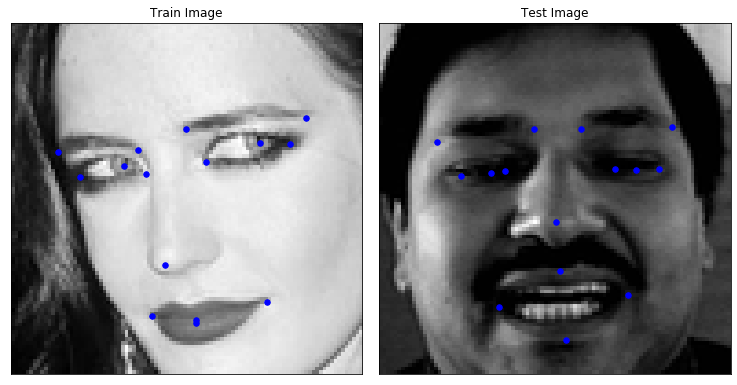

In [13]:
# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 12
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Train Image')
ax.imshow(X_train[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train[aug_img_idx, range(0, 30, 2)], Y_train[aug_img_idx, range(1, 30, 2)], marker = 'o', s=30, color='b')
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('Test Image')
ax.imshow(X_test[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_test[aug_img_idx, range(0, 30, 2)], Y_test[aug_img_idx, range(1, 30, 2)], marker = 'o', s=30, color='b')

### Split the Datasets for Modeling

Based on the analysis of the given Kaggle training dataset done in the Baseline submission of the project, we found that out of the 30 keypoint labels, only 8 keypoints had data for more than 7000 images. 
The remaining 22 keypoint labels are present for only less than 3000 images. 
This demarcation in the labeling inconsistensies lead us to defining our modeling dataset(s) with the following approch:

    - D1 - First dataset will comprise of all the 8 keypoints present for 7000+ images. We will have one model trained on this dataset.
    - D2 - Second dataset will comprise of the remaining 22 keypoints present for less than 3000 images. Have a second model trained on this dataset. 
    - Do prediction on the Kaggle Test Data on both models. Combine the 2 sets of predictions to determine overall performance.


#### Dataset #1 8 Keypoints
* left_eye_center x, y
* right_eye_center x, y
* node_tip x, y
* mouth_center_bottom_lip x, y

We will have 7000 images with 8 keypoint labels as shown below after trimming out missing data.

In [14]:
# Dataset 1

# Filter the split dataset based on labels for only 8 keypoints as defined above
d1_label_indices = [0, 1, 2, 3, 20, 21, 28, 29]
Y_train_d1 = np.copy(Y_train[:, d1_label_indices])
Y_val_d1 = np.copy(Y_val[:, d1_label_indices])

# Remove missing labels from train and val sets
# Get list of non-missing labels
index_list_tr = ~np.isnan(Y_train_d1).any(axis=1)
index_list_val = ~np.isnan(Y_val_d1).any(axis=1)

# Now define the final input images and keypoint labels for train and val datasets for Dataset 1
X_train_d1 = np.copy(X_train[index_list_tr])
Y_train_d1 = np.copy(Y_train_d1[index_list_tr])

X_val_d1 = np.copy(X_val[index_list_val])
Y_val_d1 = np.copy(Y_val_d1[index_list_val])

print("-- Size of train dataset for Dataset 1 --")
print("Train:" + str(X_train_d1.shape) + str(Y_train_d1.shape))

print("-- Size of val dataset for Dataset 1 --")
print("Val:" + str(X_val_d1.shape) + str(Y_val_d1.shape))

-- Size of train dataset for Dataset 1 --
Train:(6239, 9216)(6239, 8)
-- Size of val dataset for Dataset 1 --
Val:(690, 9216)(690, 8)


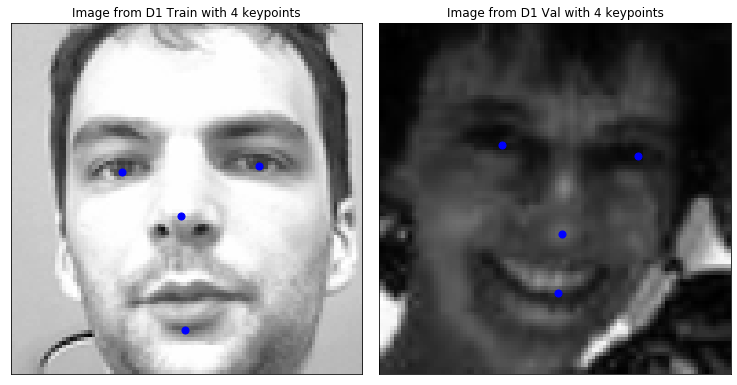

In [15]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 14
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Image from D1 Train with 4 keypoints')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'o', s=50, color='b')

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('Image from D1 Val with 4 keypoints')
ax.imshow(X_val_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_val_d1[aug_img_idx, range(0, 8, 2)], Y_val_d1[aug_img_idx, range(1, 8, 2)], marker = 'o', s=50, color='b')

#### Dataset #2 22 Keypoints
* left_eye_inner_corner x, y
* left_eye_outer_corner x, y
* right_eye_inner_corner x, y
* right_eye_outer_corner x, y
* left_eyebrow_inner_end x, y
* left_eyebrow_outer_end x, y
* right_eyebrow_inner_end x, y
* right_eyebrow_outer_end x, y
* mouth_left_corner x, y
* mouth_right_corner x, y
* mouth_center_top_lip x, y

We will have 2155 images with 22 keypoint labels as shown below after trimming out missing data.

In [16]:
# Dataset 2

# Filter the master dataset based on labels for only 22 keypoints as defined above
d2_label_indices = list(range(4, 20)) + list(range(22, 28))
Y_train_d2 = np.copy(Y_train[:, d2_label_indices])
Y_val_d2 = np.copy(Y_val[:, d2_label_indices])

# Remove missing labels from traiin and val sets
# Get list of non-missing labels
index_list_tr = ~np.isnan(Y_train_d2).any(axis=1)
index_list_val = ~np.isnan(Y_val_d2).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d2 = np.copy(X_train[index_list_tr])
Y_train_d2 = Y_train_d2[index_list_tr]

X_val_d2 = np.copy(X_val[index_list_val])
Y_val_d2 = np.copy(Y_val_d2[index_list_val])

print("-- Size of train dataset for Dataset 2 --")
print("Train:" + str(X_train_d2.shape) + str(Y_train_d2.shape))

print("-- Size of val dataset for Dataset 2 --")
print("Val:" + str(X_val_d2.shape) + str(Y_val_d2.shape))


-- Size of train dataset for Dataset 2 --
Train:(1934, 9216)(1934, 22)
-- Size of val dataset for Dataset 2 --
Val:(200, 9216)(200, 22)


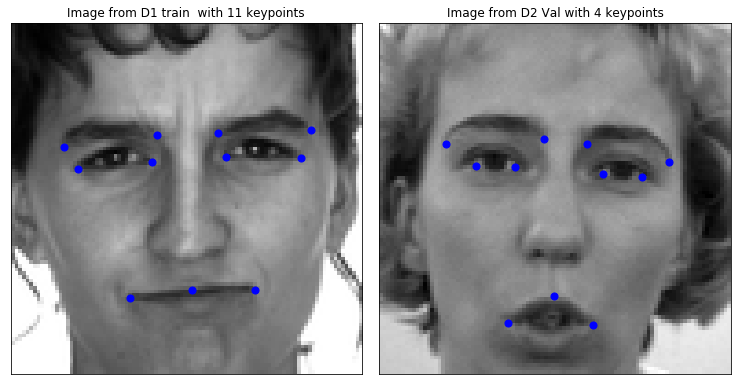

In [17]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 14
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Image from D1 train  with 11 keypoints')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'o', s=50, color='b')

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('Image from D2 Val with 4 keypoints')
ax.imshow(X_val_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_val_d2[aug_img_idx, range(0, 22, 2)], Y_val_d2[aug_img_idx, range(1, 22, 2)], marker = 'o', s=50, color='b')

#### Apply data transformation techniques to augment train data on both datasets D1 and D2

##### 1. Rotation at 10 degrees

In [18]:
degree = 10
# Transform train data for dataset 1 with rotation of its images and keypoints
X_train_d1_rotate_10 = rotate_images(X_train_d1.reshape(len(X_train_d1), 96, 96, 1), degree, True)
Y_train_d1_rotate_10 = rotate_keypoints(Y_train_d1, degree, 8)

print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_10.shape, Y_train_d1_rotate_10.shape))

Train d1 with rotation: (6239, 96, 96, 1) (6239, 8)


In [19]:
# Transform train data for dataset 2 with rotation of its images and keypoints
X_train_d2_rotate_10 = rotate_images(X_train_d2.reshape(len(X_train_d2), 96, 96, 1), degree, True)
Y_train_d2_rotate_10 = rotate_keypoints(Y_train_d2, degree, 22)

print("Train d2 with rotation: {} {}".format(X_train_d2_rotate_10.shape, Y_train_d2_rotate_10.shape))

Train d2 with rotation: (1934, 96, 96, 1) (1934, 22)


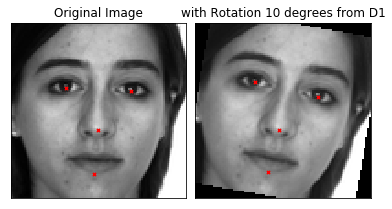

In [20]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation 10 degrees from D1')
ax.imshow(X_train_d1_rotate_10[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_10[aug_img_idx, range(0, 8, 2)], Y_train_d1_rotate_10[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

##### 2. Histogram Equalization

In [21]:
# Transform train data for dataset 1 with histogram equalization of image pixels
X_train_d1_hist_eq = histogram_eq(X_train_d1.reshape(-1, 96*96), False)
Y_train_d1_hist_eq = Y_train_d1.copy()

print(X_train_d1_hist_eq.shape)

(6239, 9216)


In [22]:
# Transform train data for dataset 1 with histogram equalization of image pixels
X_train_d2_hist_eq = histogram_eq(X_train_d2.reshape(-1, 96*96), False)
Y_train_d2_hist_eq = Y_train_d2.copy()

print(X_train_d2_hist_eq.shape)

(1934, 9216)


In [103]:
# Also save these arrays to use in other notebooks and across users
#np.save('X_train_d1_hist_eq.npy', X_train_d1_hist_eq)
#np.save('Y_train_d1_hist_eq.npy', Y_train_d1_hist_eq)

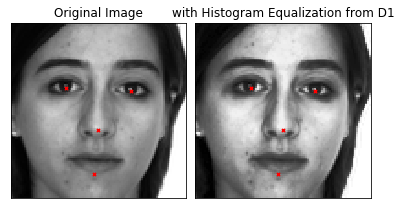

In [23]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization from D1')
ax.imshow(X_train_d1_hist_eq[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_hist_eq[aug_img_idx, range(0, 8, 2)], Y_train_d1_hist_eq[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

##### 3. Gaussian Blurring


In [24]:
# Transform train data for dataset 1 with gaussian blurring of image pixels
X_train_d1_blur = gaussion_blur(X_train_d1.reshape(-1, 96, 96, 1))
Y_train_d1_blur = Y_train_d1.copy()

In [25]:
# Transform train data for dataset 2 with gaussian blurring of image pixels
X_train_d2_blur = gaussion_blur(X_train_d2.reshape(-1, 96, 96, 1))
Y_train_d2_blur = Y_train_d2.copy()

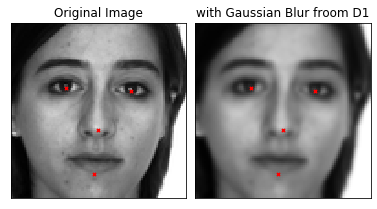

In [26]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Gaussian Blur froom D1')
ax.imshow(X_train_d1_blur[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_blur[aug_img_idx, range(0, 8, 2)], Y_train_d1_blur[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

## Data Augmentation

Here we will use the transformed datasets to augment existing train datasets for d1 and d2.
We will create a simple CNN Model to do the training of the augmented train data and evaluate performance.

#### Step 1. Augment D1 and D2 train data sets with its rotated images and keypoints at 10 degrees

In [27]:
# Augment train data for dataset 2 with rotation at 10 degrees to its images and keypoints
X_train_d1_rotate_10_comb = np.concatenate((X_train_d1, X_train_d1_rotate_10.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_10_comb = np.concatenate((Y_train_d1, Y_train_d1_rotate_10), axis = 0)
print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_10_comb.shape, Y_train_d1_rotate_10_comb.shape))



Train d1 with rotation: (12478, 96, 96, 1) (12478, 8)


In [28]:
# Augment train data for dataset 2 with rotation at 10 degrees to its images and keypoints
X_train_d2_rotate_10_comb = np.concatenate((X_train_d2, X_train_d2_rotate_10.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_10_comb = np.concatenate((Y_train_d2, Y_train_d2_rotate_10), axis = 0)
print("Train d2 with rotation: {} {}".format(X_train_d2_rotate_10_comb.shape, Y_train_d2_rotate_10_comb.shape))


Train d2 with rotation: (3868, 96, 96, 1) (3868, 22)


#### Step 2: Augment the expanded datasets to also include Blurring of images from original D1 and D2

In [29]:
# Combine Rotation and Blurring for D1
X_train_d1_rotate_blur = np.concatenate((X_train_d1_rotate_10_comb, X_train_d1_blur), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_blur = np.concatenate((Y_train_d1_rotate_10_comb, Y_train_d1_blur), axis = 0)

print("Train d1 with rotate+blur: {} {}".format(X_train_d1_rotate_blur.shape, Y_train_d1_rotate_blur.shape))

Train d1 with rotate+blur: (18717, 96, 96, 1) (18717, 8)


In [30]:
# Combine Rotation and Blurring for D2
X_train_d2_rotate_blur = np.concatenate((X_train_d2_rotate_10_comb, X_train_d2_blur), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_blur = np.concatenate((Y_train_d2_rotate_10_comb, Y_train_d2_blur), axis = 0)

print("Train d2 with rotate+blur: {} {}".format(X_train_d2_rotate_blur.shape, Y_train_d2_rotate_blur.shape))

Train d2 with rotate+blur: (5802, 96, 96, 1) (5802, 22)


#### Step: 3: Finally Augment the datasets with Rotated and Blurred Images with Histogram Equalization of Image Pixels

In [31]:
# Combine Rotation, Histogram Equalization and Blur for D1
# We have already combined Rotation and HE. Concatenate this with Blur
X_train_d1_rotate_he_blur = np.concatenate((X_train_d1_rotate_blur, X_train_d1_hist_eq.reshape(-1, 96, 96, 1)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_he_blur = np.concatenate((Y_train_d1_rotate_blur, Y_train_d1_hist_eq), axis = 0)

print("Train d1 with rotate+he+blur: {} {}".format(X_train_d1_rotate_he_blur.shape, Y_train_d1_rotate_he_blur.shape))

Train d1 with rotate+he+blur: (24956, 96, 96, 1) (24956, 8)


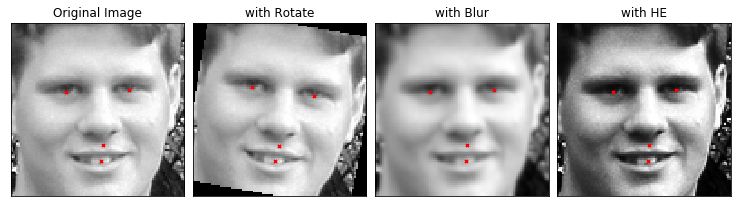

In [32]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
ax.set_title('with Rotate')
ax.imshow(X_train_d1_rotate_he_blur[6240].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he_blur[6240, range(0, 8, 2)], Y_train_d1_rotate_he_blur[6240, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
ax.set_title('with Blur')
ax.imshow(X_train_d1_rotate_he_blur[12479].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he_blur[12479, range(0, 8, 2)], Y_train_d1_rotate_he_blur[12479, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
ax.set_title('with HE')
ax.imshow(X_train_d1_rotate_he_blur[18718].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he_blur[18718, range(0, 8, 2)], Y_train_d1_rotate_he_blur[18718, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [33]:
# Combine Rotation, Histogram Equalization and Blur for D2
# We have already combined Rotation and HE. Concatenate this with Blur
X_train_d2_rotate_he_blur = np.concatenate((X_train_d2_rotate_blur, X_train_d2_hist_eq.reshape(-1, 96, 96, 1)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_he_blur = np.concatenate((Y_train_d2_rotate_blur, Y_train_d2_hist_eq), axis = 0)

print("Train d2 with rotate+he+blur: {} {}".format(X_train_d2_rotate_he_blur.shape, Y_train_d2_rotate_he_blur.shape))

Train d2 with rotate+he+blur: (7736, 96, 96, 1) (7736, 22)


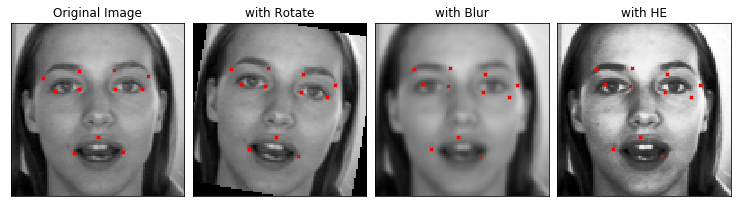

In [34]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1,22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
ax.set_title('with Rotate')
ax.imshow(X_train_d2_rotate_he_blur[1935].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he_blur[1935, range(0, 22, 2)], Y_train_d2_rotate_he_blur[1935, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
ax.set_title('with Blur')
ax.imshow(X_train_d2_rotate_he_blur[3869].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he_blur[1935, range(0, 22, 2)], Y_train_d2_rotate_he_blur[1935, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')


# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
ax.set_title('with HE')
ax.imshow(X_train_d2_rotate_he_blur[5803].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he_blur[1935, range(0, 22, 2)], Y_train_d2_rotate_he_blur[1935, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [35]:
# Final Augmented Train Data Sets:

# D1 and D2
print("D1 with Rotate + HE + Blur: {} {}".format(X_train_d1_rotate_he_blur.shape, Y_train_d1_rotate_he_blur.shape))
print("D2 with Rotate + HE + Blur: {} {}".format(X_train_d2_rotate_he_blur.shape, Y_train_d2_rotate_he_blur.shape))

D1 with Rotate + HE + Blur: (24956, 96, 96, 1) (24956, 8)
D2 with Rotate + HE + Blur: (7736, 96, 96, 1) (7736, 22)


In [36]:
# Reshape Val datasets before feeding into models
X_val_d1 = X_val_d1.reshape(-1, 96, 96, 1)
X_val_d2 = X_val_d2.reshape(-1, 96, 96, 1)

<b> Finally we have our 2 augmented train datasets D1 and D2 which have tripled in size. This will help with more variance in training features and samples which will help with generalization and improve performance of Convolutional Neural Network models which we will build. </b>

## Exploring improved CNN Architectures from our VGG-16 inspiration

In [37]:
# Helper function to find RMSE(Root Mean Squared Error)
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# The early stop callback will terminate a training session if no progress is being made
#early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15, mode='auto')
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Reduce learning Rate on Plateau to reduce the learning rate once learning stagnates. 
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=10, factor= .4, min_lr=.00001)

In [149]:
# Training and Validation tests for training D1
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
#X_t_d1, X_v_d1, Y_t_d1, Y_v_d1 = train_test_split(X_train_d1_rotate_he_blur, Y_train_d1_rotate_he_blur, \
#                                                  test_size=0.2, random_state=42, shuffle=True)

#print("Train: {} {}".format(X_t_d1.shape, Y_t_d1.shape))
#print("Val: {} {}".format(X_v_d1.shape, Y_v_d1.shape))

In [150]:
# Training and Validation tests for training D2
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
#X_t_d2, X_v_d2, Y_t_d2, Y_v_d2 = train_test_split(X_train_d2_rotate_he_blur, Y_train_d2_rotate_he_blur, \
#                                                  test_size=0.2, random_state=42, shuffle=True)

#print("Train: {} {}".format(X_t_d2.shape, Y_t_d1.shape))
#print("Val: {} {}".format(X_v_d2.shape, Y_v_d1.shape))

### Model 1: 

    - Use the same number of convolutional layers as in VGG-16 inspired which is 5
    - Use smaller filter depths of 32-64-128-256-512 in each convolutional layer  with the same 3X3 kernel. 
    - Similarly reduce the hidden units in Dense layer to 512.
    - We will continue to use callbacks using Keras' EarlyStopping and ReduceLRonPlateau.


In [38]:
# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def cnn_model_1(points):
    model = Sequential()
    model.add(InputLayer(input_shape=[96, 96, 1]))
    
    #model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(points))

    return model

In [39]:
# Create model for D1
model1_d1 = cnn_model_1(8)
model1_d1.summary()
epochs = 100
batch_size = 50

model1_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model1_d1_history = model1_d1.fit(X_train_d1_rotate_he_blur, Y_train_d1_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d1, Y_val_d1), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

   


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)      

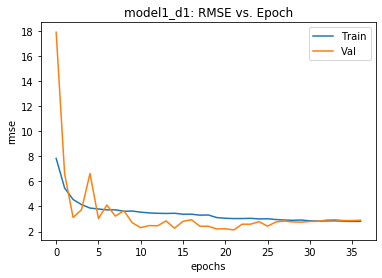

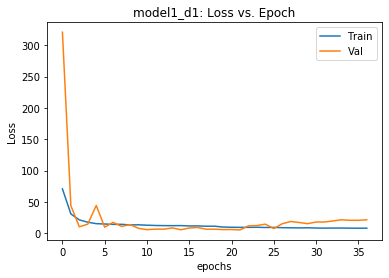

Val RMSE: 2.1283557415008545
Train RMSE: 2.803452730178833 
Val Accuracy: 0.9898550510406494
Train Accuracy: 0.9937890768051147 


In [40]:
# Call function to plot metrics of results
plot_metrics('model1_d1', model1_d1_history, True)

In [41]:
# Create model for D2
model1_d2 = cnn_model_1(22)
model1_d2.summary()
epochs = 100
batch_size = 50

model1_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model1_d2_history = model1_d2.fit(X_train_d2_rotate_he_blur, Y_train_d2_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d2, Y_val_d2), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

   


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

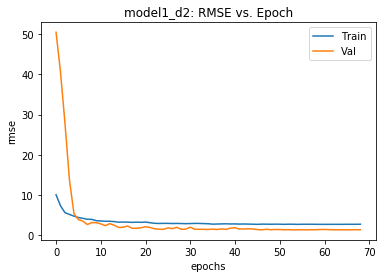

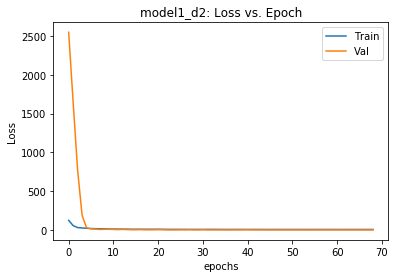

Val RMSE: 1.3277796506881714
Train RMSE: 2.708035469055176 


In [42]:
# Call function to plot metrics of results
plot_metrics('model1_d2', model1_d2_history, False)

In [47]:
model1_d1_score = model1_d1.evaluate(X_val_d1.reshape(-1, 96, 96, 1), Y_val_d1)
print("Model 1 d1 Val. {}: {}".format(model1_d1.metrics_names[2], model1_d1_score[2]))
model1_d2_score = model1_d2.evaluate(X_val_d2.reshape(-1, 96, 96, 1), Y_val_d2)
print("Model1 d2Val. {}: {}".format(model1_d2.metrics_names[2], model1_d2_score[2]))

690/690 [==============================] - 0s 653us/step
Model 1 d1 Val. accuracy: 0.9884058237075806
200/200 [==============================] - 0s 1ms/step
Model1 d2Val. accuracy: 0.8700000047683716


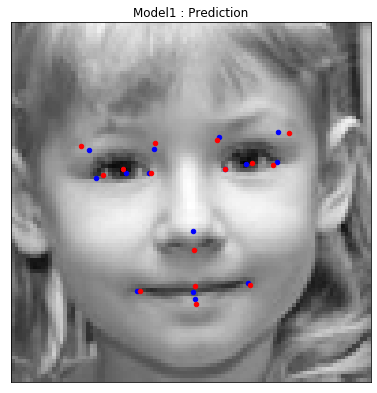

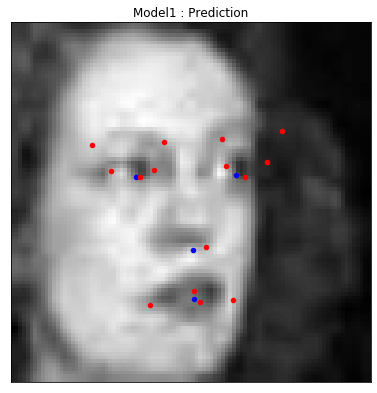

In [48]:
# Call functions to make predictions on held out test data
model_predict(model1_d1, model1_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Model1 : Prediction')
model_predict(model1_d1, model1_d2, X_test, Y_test, 55, d1_label_indices, d2_label_indices, 'Model1 : Prediction')

<b>Model 1 Observations:</b> Reducing the filter sizes in the convolution layers definitely helped with the training time and performance of the model. The validation accuracy came to 0.98 and train accuracy to 0.87. From the RMSE vs. Epoch plot, the model exhibits underfitting of the training data. This could be because of the much larger augmented training data vs. the smaller validation dataset. 

The prediction plots of the 2 test data images are not on point yet especially with the 2nd image where the some predicted points are out of range of the face. The model clearly didn't learn the keypoint positions of angled face. 

### Model 2

Here we will add another of convoluted layer after each convoluted layer with the same filter depth and stride as the one it's stacked under. This helps the extracted features from the previous layer to learn more complex or abstract features. This technique has been known to be successful in image processing and is used in the classic VGG-16 model as well. Would this result in more computational time?

Bath Normalization is also added after the additional convolutional layers. 

In [49]:
# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def cnn_model_2(points):
    model = Sequential()
    model.add(InputLayer(input_shape=[96, 96, 1]))
    
    #model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(points))

    return model

In [50]:
# Create model for D1
model2_d1 = cnn_model_2(8)
model2_d1.summary()
epochs = 100
batch_size = 50

model2_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model2_d1_history = model2_d1.fit(X_train_d1_rotate_he_blur, Y_train_d1_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d1, Y_val_d1), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 64)       

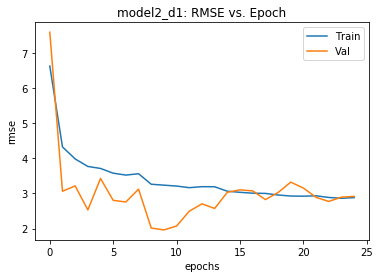

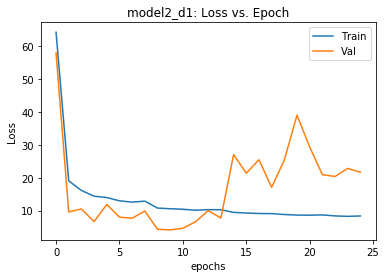

Val RMSE: 1.9601242542266846
Train RMSE: 2.862025260925293 
Val Accuracy: 0.991304337978363
Train Accuracy: 0.9931479692459106 


In [51]:
# Call function to plot metrics of results
plot_metrics('model2_d1', model2_d1_history, True)

In [54]:
# Create model for D2
model2_d2 = cnn_model_2(22)
model2_d2.summary()
epochs = 100
batch_size = 50

model2_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D2
%time model2_d2_history = model2_d2.fit(X_train_d2_rotate_he_blur, Y_train_d2_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d2, Y_val_d2), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_31 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_33 (Batc (None, 48, 48, 64)       

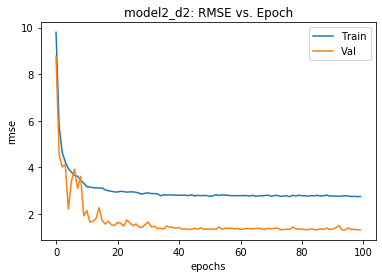

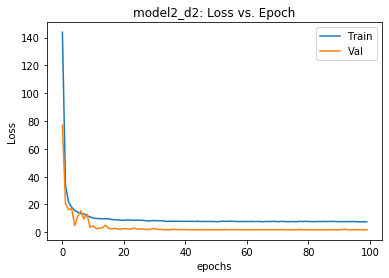

Val RMSE: 1.3096847534179688
Train RMSE: 2.7380356788635254 
Val Accuracy: 0.9049999713897705
Train Accuracy: 0.8572905659675598 


In [55]:
# Call function to plot metrics of results
plot_metrics('model2_d2', model2_d2_history, True)

In [56]:
model2_d1_score = model2_d1.evaluate(X_val_d1.reshape(-1, 96, 96, 1), Y_val_d1)
print("Model1 d1 Val. {}: {}".format(model1_d1.metrics_names[2], model2_d1_score[2]))
model2_d2_score = model2_d2.evaluate(X_val_d2.reshape(-1, 96, 96, 1), Y_val_d2)
print("Model2 d2 Val. {}: {}".format(model1_d2.metrics_names[2], model2_d2_score[2]))

690/690 [==============================] - 1s 2ms/step
Model1 d1 Val. accuracy: 0.9869565367698669
200/200 [==============================] - 0s 2ms/step
Model2 d2 Val. accuracy: 0.8899999856948853


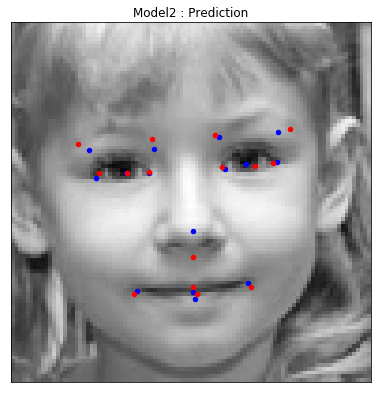

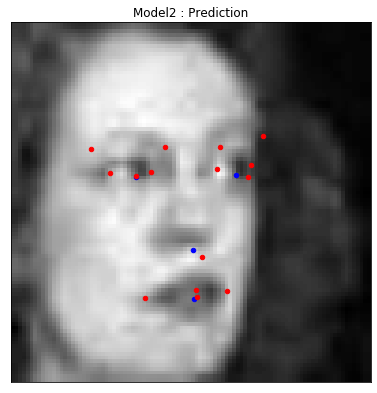

In [57]:
# Call functions to make predictions on held out test data
model_predict(model2_d1, model2_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Model2 : Prediction')
model_predict(model2_d1, model2_d2, X_test, Y_test, 55, d1_label_indices, d2_label_indices, 'Model2 : Prediction')

<b>Model 2 Observations:</b> Adding stacked convolutional layers helped some better predictions of keypoints on test data images above. The predictions are much closer to the actual keypoints provided in the samples. However, by looking at the rmse vs. epochs plot, again due to the larger training data, the model suffers from underfitting. 

### Model 3

So far we have used 'ReLU' - Rectified Linear Unit as activation function in all convolutional layers. This function is known for 'dead relu' problem where components of the network are most likely never updated to a new value and it also does not avoid the exploding gradient problem. Leaky Rectified Linear Unit(Leaky ReLU) is another activation function is such that if input is > 0 , then output is x but if input is less than 0, the output will be alpha times x. This solves the dead relu problem because the gradients can no longer be stuck at 0 and avoids vanishing gradient problem. However we still have the exploding gradient problem.  ELU (Exponential Linear Unit) is another activation function which uses alpha which solves the exploding gradients problem but it is computionally expensive because of the exponential function, so decided to skip using this. 

https://mlfromscratch.com/activation-functions-explained/#/

So in this model, we will use Leaky ReLU activation after each convolutional layer. 

In [63]:
# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def cnn_model_3(points):
    model = Sequential()
    
    model.add(InputLayer(input_shape=[96, 96, 1]))
    
    model.add(Conv2D(32, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(256, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(points))

    return model

In [64]:
# Create model for D1
model3_d1 = cnn_model_3(8)
model3_d1.summary()
epochs = 100
batch_size = 50

model3_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model3_d1_history = model3_d1.fit(X_train_d1_rotate_he_blur, Y_train_d1_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d1, Y_val_d1), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 48, 48, 32)       

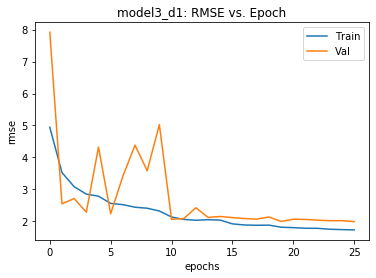

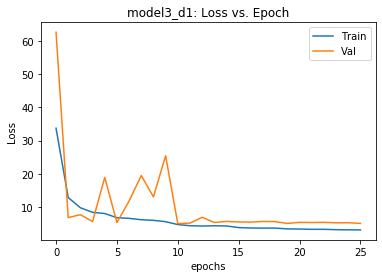

Val RMSE: 1.9930747747421265
Train RMSE: 1.7337108850479126 
Val Accuracy: 0.9942029118537903
Train Accuracy: 0.9964737892150879 


In [66]:
# Call function to plot metrics of results
plot_metrics('model3_d1', model3_d1_history, True)

In [67]:
# Create model for D2
model3_d2 = cnn_model_3(22)
model3_d2.summary()
epochs = 100
batch_size = 50

model3_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D2
%time model3_d2_history = model3_d2.fit(X_train_d2_rotate_he_blur, Y_train_d2_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d2, Y_val_d2), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 48, 48, 32)       

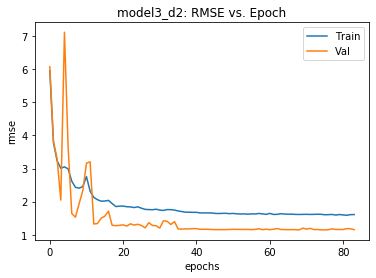

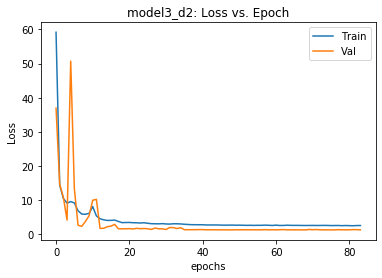

Val RMSE: 1.1456372737884521
Train RMSE: 1.5883755683898926 
Val Accuracy: 0.8899999856948853
Train Accuracy: 0.8879265785217285 


In [73]:
# Call function to plot metrics of results
plot_metrics('model3_d2', model3_d2_history, True)

In [74]:
model3_d1_score = model3_d1.evaluate(X_val_d1.reshape(-1, 96, 96, 1), Y_val_d1)
print("Model3 d1 Val. {}: {}".format(model3_d1.metrics_names[2], model3_d1_score[2]))
model3_d2_score = model3_d2.evaluate(X_val_d2.reshape(-1, 96, 96, 1), Y_val_d2)
print("Model3 d2 Val. {}: {}".format(model3_d2.metrics_names[2], model3_d2_score[2]))

690/690 [==============================] - 1s 2ms/step
Model3 d1 Val. accuracy: 0.9898550510406494
200/200 [==============================] - 0s 2ms/step
Model3 d2 Val. accuracy: 0.875


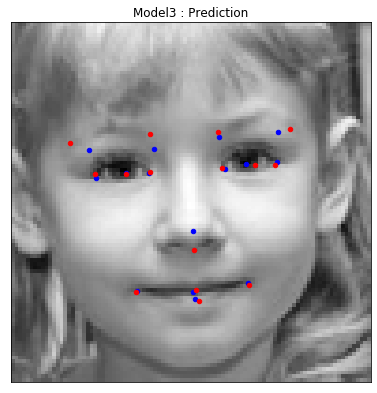

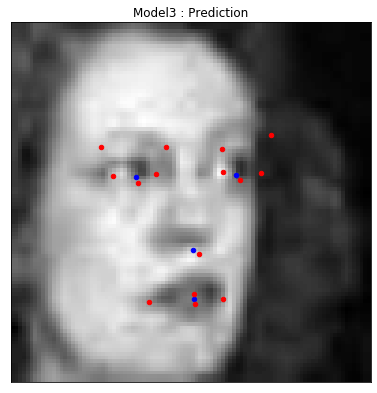

In [75]:
# Call functions to make predictions on held out test data
model_predict(model3_d1, model3_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Model3 : Prediction')
model_predict(model3_d1, model3_d2, X_test, Y_test, 55, d1_label_indices, d2_label_indices, 'Model3 : Prediction')

<b>Model 3 Observations:</b> Looks like didn't help much as we see the predicted keypoints on the images are worse than that from Model 2. Also the Loss/Epochs and Val/Epochs plot shows a big spike for Val. data. It seems like the model was trying to learn difficult examples. Do we need to tune some other hyperparameter along with Leaky RELU of completely omit it and stick with ReLU? 

### Model 4

Getting back to ReLU again, this time for the activation in the first fully connected dense layer, it is mentioned in some of the technical forums that for regression problems, a better option would be to use a 'linear' activation function.
https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f

In [79]:
# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def cnn_model_4(points):
    model = Sequential()
    
    model.add(InputLayer(input_shape=[96, 96, 1]))
    
    model.add(Conv2D(32, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(256, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding = 'same', use_bias = False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='linear'))
    model.add(Dropout(0.1))
    model.add(Dense(points))

    return model

In [80]:
# Create model for D1
model4_d1 = cnn_model_4(8)
model4_d1.summary()
epochs = 100
batch_size = 50

model4_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model4_d1_history = model4_d1.fit(X_train_d1_rotate_he_blur, Y_train_d1_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d1, Y_val_d1), \
                              #callbacks=[early_stop, reduce_lr], verbose = 2)
                              callbacks=[reduce_lr], verbose = 2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 48, 48, 32)       

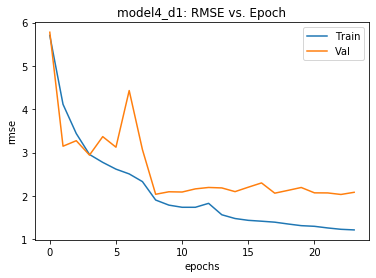

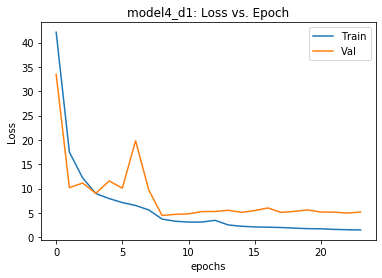

Val RMSE: 2.0327796936035156
Train RMSE: 1.2147654294967651 
Val Accuracy: 0.9927536249160767
Train Accuracy: 0.997555673122406 


In [81]:
# Call function to plot metrics of results
plot_metrics('model4_d1', model4_d1_history, True)

In [82]:
# Create model for D2
model4_d2 = cnn_model_4(22)
model4_d2.summary()
epochs = 100
batch_size = 50

model4_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model4_d2_history = model4_d2.fit(X_train_d2_rotate_he_blur, Y_train_d2_rotate_he_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d2, Y_val_d2), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 48, 48, 32)      

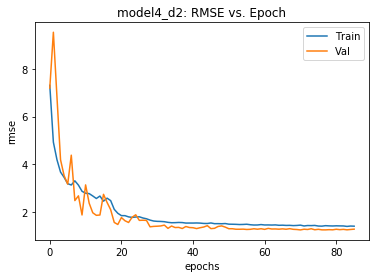

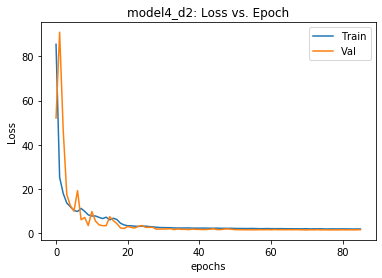

Val RMSE: 1.252590298652649
Train RMSE: 1.3991894721984863 
Val Accuracy: 0.875
Train Accuracy: 0.8986556529998779 


In [83]:
# Call function to plot metrics of results
plot_metrics('model4_d2', model4_d2_history, True)

In [84]:
model4_d1_score = model4_d1.evaluate(X_val_d1.reshape(-1, 96, 96, 1), Y_val_d1)
print("Model4 d1 Val. {}: {}".format(model4_d1.metrics_names[2], model4_d1_score[2]))
model4_d2_score = model4_d2.evaluate(X_val_d2.reshape(-1, 96, 96, 1), Y_val_d2)
print("Model4 d2 Val. {}: {}".format(model4_d2.metrics_names[2], model4_d2_score[2]))

690/690 [==============================] - 1s 1ms/step
Model4 d1 Val. accuracy: 0.9927536249160767
200/200 [==============================] - 0s 1ms/step
Model4 d2 Val. accuracy: 0.8600000143051147


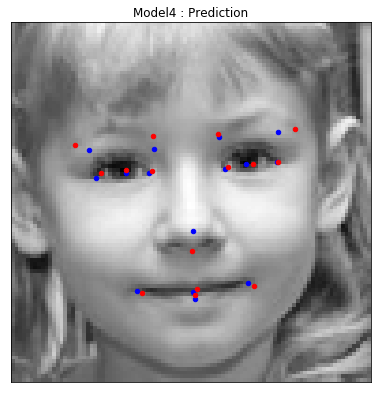

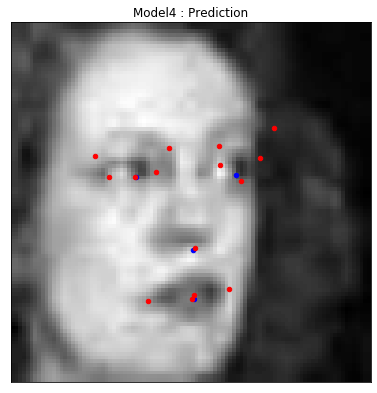

In [85]:
# Call functions to make predictions on held out test data
model_predict(model4_d1, model4_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Model4 : Prediction')
model_predict(model4_d1, model4_d2, X_test, Y_test, 55, d1_label_indices, d2_label_indices, 'Model4 : Prediction')

<b>Model 4 Observations:</b> F

### Model 5

To overcome the problems of underfitting in our models, we will scale down the training data by half and retaining some augmentation with data transformation. This is done by first augmenting train data for d1 and d2 with corresponding rotated images at 10 degrees. This will double the dataset. Then apply histogram equalization to this entire set followed by blurring. 
We will use Model 3 with Leaky ReLU activations after each convolutional layer to see if it improves the performance of the model and avoid underfitting.

##### Define the new training datasets for d1 and d2

In [89]:
# Append rotated images and keypoints at 10 degrees to train data of d1
X_d1_rotate = np.zeros((X_train_d1.shape), dtype = np.float64)
X_d1_rotate = rotate_images(X_train_d1.reshape(len(X_train_d1), 96, 96, 1), 10, flag = True)

# Apply Histogram Equalization to the augmented train data
X_d1_rotate = np.concatenate((X_train_d1, X_d1_rotate.reshape(-1, 96*96)), axis = 0)
X_d1_ro_hist = X_d1_rotate.copy()
X_d1_ro_hist = histogram_eq(X_d1_ro_hist.reshape(-1, 96*96), False)

# Apply blurring to the tramsformed images after applying Histogram Equalization
X_d1_ro_hist_blur = X_d1_ro_hist.copy()
X_d1_ro_hist_blur = gaussion_blur(X_d1_ro_hist_blur.reshape(-1, 96, 96, 1)).reshape(-1, 96, 96, 1)

# Rotate keypoints 
Y_d1_rotate = np.zeros(Y_train_d1.shape, dtype = 'float64')
Y_d1_rotate = rotate_keypoints(Y_train_d1, 10, 8)

Y_d1_ro_hist_blur = np.concatenate((Y_train_d1, Y_d1_rotate), axis = 0)

print (X_d1_ro_hist_blur.shape, Y_d1_ro_hist_blur.shape)

(12478, 96, 96, 1) (12478, 8)


In [90]:
# Append rotated images and keypoints at 10 degrees to train data of d2
X_d2_rotate = np.zeros((X_train_d2.shape), dtype = np.float64)
X_d2_rotate = rotate_images(X_train_d2.reshape(len(X_train_d2), 96, 96, 1), 10, flag = True)

# Apply Histogram Equalization to the augmented train data
X_d2_rotate = np.concatenate((X_train_d2, X_d2_rotate.reshape(-1, 96*96)), axis = 0)
X_d2_ro_hist = X_d2_rotate.copy()
X_d2_ro_hist = histogram_eq(X_d2_ro_hist.reshape(-1, 96*96), False)

# Apply blurring to the tramsformed images after applying Histogram Equalization
X_d2_ro_hist_blur = X_d2_ro_hist.copy()
X_d2_ro_hist_blur = gaussion_blur(X_d2_ro_hist_blur.reshape(-1, 96, 96, 1)).reshape(-1, 96, 96, 1)

# Rotate keypoints 
Y_d2_rotate = np.zeros(Y_train_d2.shape, dtype = 'float64')
Y_d2_rotate = rotate_keypoints(Y_train_d2, 10, 22)

Y_d2_ro_hist_blur = np.concatenate((Y_train_d2, Y_d2_rotate), axis = 0)

print (X_d2_ro_hist_blur.shape, Y_d2_ro_hist_blur.shape)

(3868, 96, 96, 1) (3868, 22)


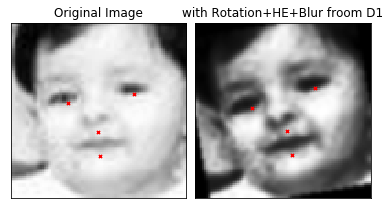

In [103]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation+HE+Blur froom D1')
ax.imshow(X_d1_ro_hist_blur[6239].reshape(96,96),cmap='gray')
ax.scatter(Y_d1_ro_hist_blur[6239, range(0, 8, 2)], Y_d1_ro_hist_blur[6239, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

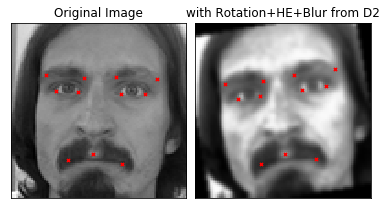

In [102]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation+HE+Blur from D2')
ax.imshow(X_d2_ro_hist_blur[1934].reshape(96,96),cmap='gray')
ax.scatter(Y_d2_ro_hist_blur[1934, range(0, 22, 2)], Y_d2_ro_hist_blur[1934, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [93]:
# Create model for D1
model5_d1 = cnn_model_4(8)
model5_d1.summary()
epochs = 100
batch_size = 50

model5_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model5_d1_history = model5_d1.fit(X_d1_ro_hist_blur, Y_d1_ro_hist_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d1, Y_val_d1), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_92 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 48, 48, 32)      

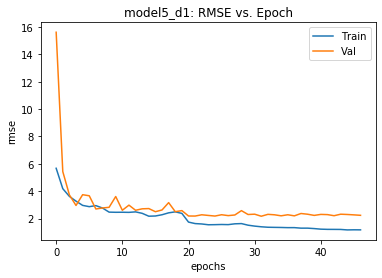

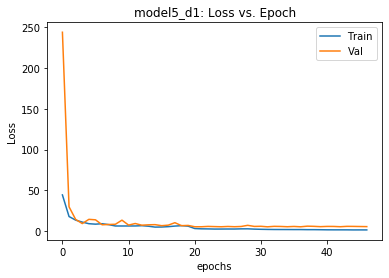

Val RMSE: 2.1755523681640625
Train RMSE: 1.176167368888855 
Val Accuracy: 0.991304337978363
Train Accuracy: 0.998236894607544 


In [94]:
# Call function to plot metrics of results
plot_metrics('model5_d1', model5_d1_history, True)

In [95]:
# Create model for D2
model5_d2 = cnn_model_4(22)
model5_d2.summary()
epochs = 100
batch_size = 50

model5_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model5_d2_history = model5_d2.fit(X_d2_ro_hist_blur, Y_d2_ro_hist_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d2, Y_val_d2), \
                              callbacks=[early_stop, reduce_lr], verbose = 2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 48, 48, 32)      

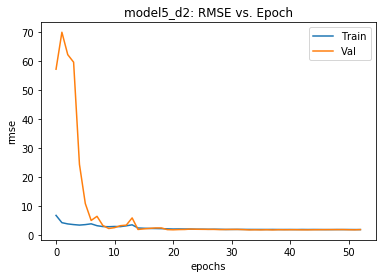

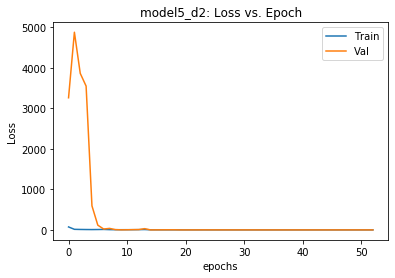

Val RMSE: 1.6742796897888184
Train RMSE: 1.7918832302093506 
Val Accuracy: 0.8500000238418579
Train Accuracy: 0.8443639874458313 


In [96]:
# Call function to plot metrics of results
plot_metrics('model5_d2', model5_d2_history, True)

In [97]:
model5_d1_score = model5_d1.evaluate(X_val_d1.reshape(-1, 96, 96, 1), Y_val_d1)
print("Model5 d1 Val. {}: {}".format(model5_d1.metrics_names[2], model5_d1_score[2]))
model5_d2_score = model5_d2.evaluate(X_val_d2.reshape(-1, 96, 96, 1), Y_val_d2)
print("Model5 d2 Val. {}: {}".format(model5_d2.metrics_names[2], model5_d2_score[2]))

690/690 [==============================] - 1s 1ms/step
Model5 d1 Val. accuracy: 0.9898550510406494
200/200 [==============================] - 0s 1ms/step
Model5 d2 Val. accuracy: 0.8349999785423279


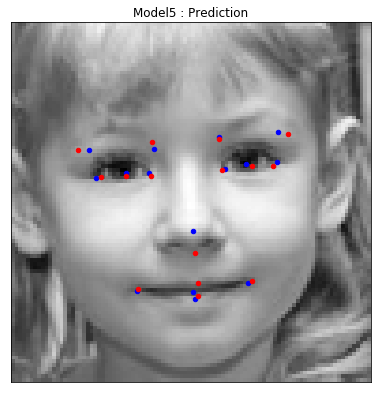

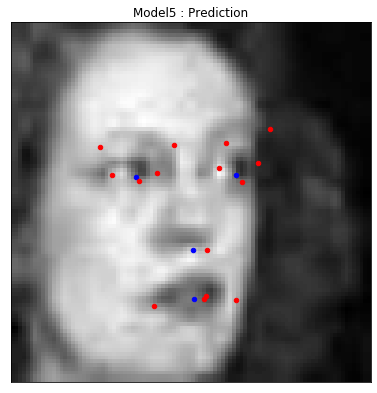

In [98]:
model_predict(model5_d1, model5_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Model5 : Prediction')
model_predict(model5_d1, model5_d2, X_test, Y_test, 55, d1_label_indices, d2_label_indices, 'Model5 : Prediction')

<b>Model 5 Observations: </b> From the rmse/epochs, loss/epochs plots we can see there is not much overfitting or underfitting and the model seems to be better calibrated. So the reduction in dataset size definitely helped. However, there are some spikes which means the model could could be learning some difficult examples as we applied triple transform augmentation(Rotate+HE+Blue) to the training dataset. The 2 images with results of the predictions from the model show that it is comes close to that of model 2 which had some accurate predictions. But we still see some keypoints predicted outside the face in image 2. 

## Model 6

Here we again use the same triple trannformed augmented dataset used to train model 2 to improve the performance of the model. 

In [106]:
# Create model for D1
model6_d1 = cnn_model_2(8)
model6_d1.summary()
epochs = 100
batch_size = 50

model6_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D1
%time model6_d1_history = model6_d1.fit(X_d1_ro_hist_blur, Y_d1_ro_hist_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d1, Y_val_d1), \
                              callbacks=[reduce_lr], verbose = 2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_121 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_122 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_123 (Bat (None, 48, 48, 64)      

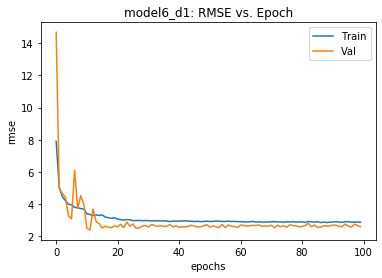

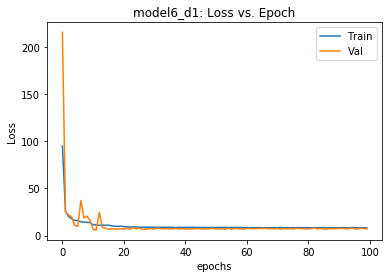

Val RMSE: 2.3916332721710205
Train RMSE: 2.848813533782959 
Val Accuracy: 0.991304337978363
Train Accuracy: 0.9939092993736267 


In [109]:
# Call function to plot metrics of results
plot_metrics('model6_d1', model6_d1_history, True)

In [107]:
# Create model for D2
model6_d2 = cnn_model_2(22)
model6_d2.summary()
epochs = 100
batch_size = 50

model6_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse, 'accuracy'])

# Fit model on D2
%time model6_d2_history = model6_d2.fit(X_d2_ro_hist_blur, Y_d2_ro_hist_blur, epochs = epochs, shuffle = False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (X_val_d2, Y_val_d2), \
                              callbacks=[reduce_lr], verbose = 2)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_131 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_132 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_133 (Bat (None, 48, 48, 64)      

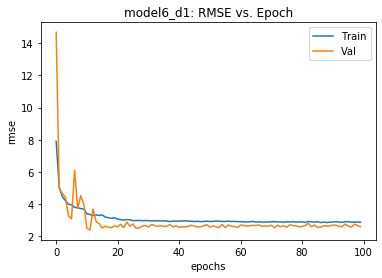

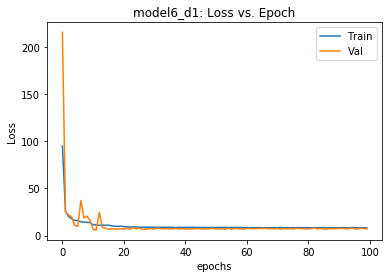

Val RMSE: 2.3916332721710205
Train RMSE: 2.848813533782959 
Val Accuracy: 0.991304337978363
Train Accuracy: 0.9939092993736267 


In [108]:
# Call function to plot metrics of results
plot_metrics('model6_d1', model6_d1_history, True)

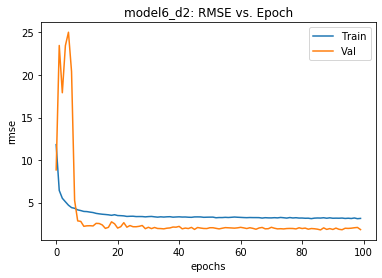

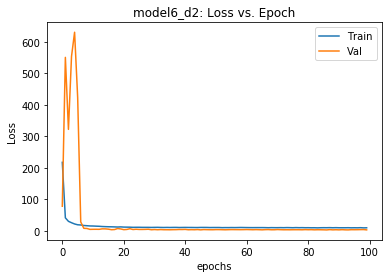

Val RMSE: 1.7922701835632324
Train RMSE: 3.1111390590667725 
Val Accuracy: 0.8600000143051147
Train Accuracy: 0.7874870896339417 


In [110]:
# Call function to plot metrics of results
plot_metrics('model6_d2', model6_d2_history, True)

In [111]:
model6_d1_score = model6_d1.evaluate(X_val_d1.reshape(-1, 96, 96, 1), Y_val_d1)
print("Model6 d1 Val. {}: {}".format(model6_d1.metrics_names[2], model6_d1_score[2]))
model6_d2_score = model6_d2.evaluate(X_val_d2.reshape(-1, 96, 96, 1), Y_val_d2)
print("Model6 d2 Val. {}: {}".format(model6_d2.metrics_names[2], model6_d2_score[2]))

690/690 [==============================] - 1s 1ms/step
Model6 d1 Val. accuracy: 0.9884058237075806
200/200 [==============================] - 0s 1ms/step
Model6 d2 Val. accuracy: 0.8349999785423279


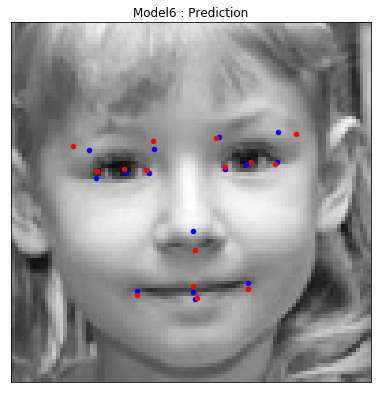

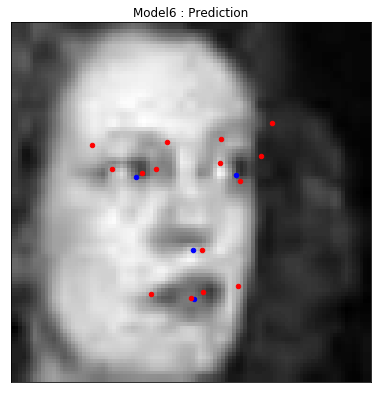

In [112]:
# Call functions to make predictions on held out test data
model_predict(model6_d1, model6_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Model6 : Prediction')
model_predict(model6_d1, model6_d2, X_test, Y_test, 55, d1_label_indices, d2_label_indices, 'Model6 : Prediction')

<b> Model 6 Observations: </b> Using the smaller triple transformed augmented dataset reduced some of the underfitting seen in Model 2 results. However, the predictions are not accurate enough as compared to model 2. 

## Conclusion

By training several models by keeping the same 6 layer convolution neural network as per our best initial VGG-16 inspired model and using the augmented dataset with data transformations, we were able to see improvement in the performance in some of the models. Model 2 and Model 5 were the best in terms of accuracy on the Validation and held out Test data. Also as per the predictions for the Kaggle submission, these 2 models scored the best amongst all as shown below. Having double stacked convolutional layer also helped. ReLU activation in Model 2 for activations at convolutional layers better performed against LeakyReLU in Model 5. We could have achieved better results with better calibrated models if we could have done more tuning of the hyperparameters like using a Grid Search around the various parameters and setting choices. In the contraints of computional time and resources this will be parked for a later time. 

#### For Kaggle Submission

In [133]:
kaggle_scores = {'Model Name' : ['AlexNet', 'VGG-16 2', 'LeNet-5', 'AlexNet 2', 'VGG-16(condensed) with split data',
                                'MobileNet', 'CNN Model 1', 'CNN Model 2', 'CNN Model 5', 'CNN Ensemble 2+5'],
                 'Description': ["AlexNet Inspired", "VGG-16 Inspired 16x2-32x2-64x3-128x3-256x3", "LeNet-5 Split Data", "AlexNet with split data",
                "Condensed 5 layers 64-728-256-1024", "Transfer Learning 50 epochs", "5 layer 16-32-64-128-256 ReLU Data Aug.",
                                "5 layer 16x2-32x2-64x2-128x2-256x2 ReLU Data Aug.",
                "5 layer 16x2-32x2-64x2-128x2-256x2 LeakyReLU Triple Transform Data Aug.", "CNN Model 2 and 5(Average)"],
                'Private Kaggle Leaderboard': [4.23367, 4.29732, 3.11456, 3.81822, 2.30058, 3.87938, 1.80883, 1.73005, 2.02078, 1.73510],
                'Public Kaggle Leaderboard': [4.28248, 4.35237, 3.21203, 4.01989, 2.62112, 3.86814, 2.16564, 2.12732, 2.30053, 2.09630]
                                 }

df_kaggle = pd.DataFrame(kaggle_scores)
display(df_kaggle)

,Model Name,Description,Private Kaggle Leaderboard,Public Kaggle Leaderboard
0,AlexNet,AlexNet Inspired,4.23367,4.28248
1,VGG-16 2,VGG-16 Inspired 16x2-32x2-64x3-128x3-256x3,4.29732,4.35237
2,LeNet-5,LeNet-5 Split Data,3.11456,3.21203
3,AlexNet 2,AlexNet with split data,3.81822,4.01989
4,VGG-16(condensed) with split data,Condensed 5 layers 64-728-256-1024,2.30058,2.62112
5,MobileNet,Transfer Learning 50 epochs,3.87938,3.86814
6,CNN Model 1,5 layer 16-32-64-128-256 ReLU Data Aug.,1.80883,2.16564
7,CNN Model 2,5 layer 16x2-32x2-64x2-128x2-256x2 ReLU Data Aug.,1.73005,2.12732
8,CNN Model 5,5 layer 16x2-32x2-64x2-128x2-256x2 LeakyReLU T...,2.02078,2.30053
9,CNN Ensemble 2+5,CNN Model 2 and 5(Average),1.73510,2.09630


### Generate Kaggle Submission File

In [113]:
# make prediction on test set

y_test_m1 = model6_d1.predict(X_test_kaggle)
y_test_m2 = model6_d2.predict(X_test_kaggle)

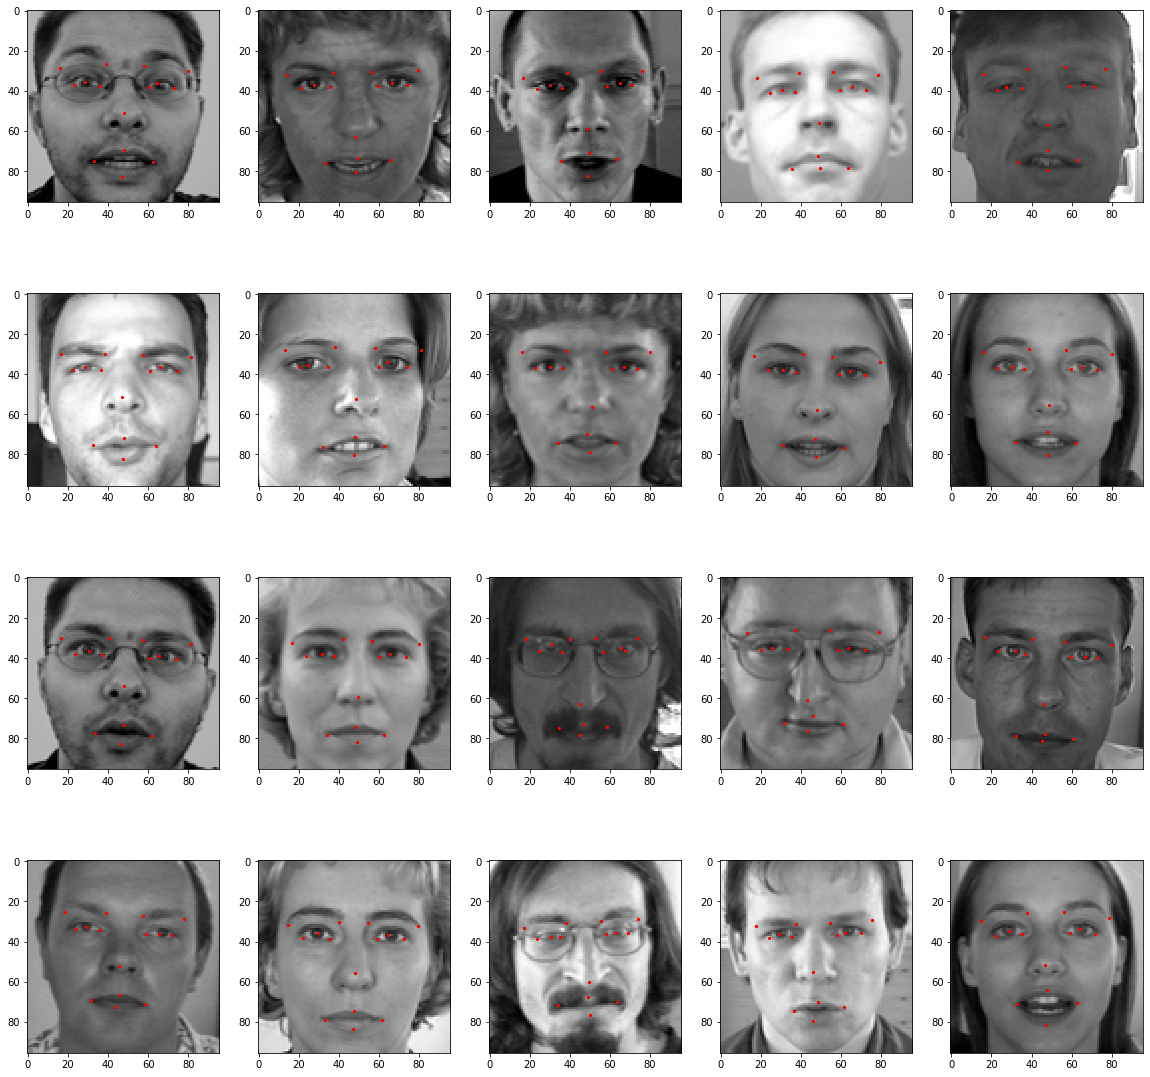

In [114]:
# combine outputs from 2 models
pts1 = [0,1,2,3,20,21,28,29]
pts2 = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27]
y_test = np.zeros((1783,30), dtype=np.float64)
y_test[:, pts1] = y_test_m1
y_test[:, pts2] = y_test_m2

# visualize a few examples
fig = plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test_kaggle[i].reshape(96, 96), cmap='gray', vmin=0, vmax=1)
    plt.scatter(y_test[i, range(0, 30, 2)], y_test[i, range(1, 30, 2)], s=5, color='r')
plt.show()

In [115]:
generate_submission(y_test, 'Model6_CNN_final')

(27124, 2)


In [119]:
submission_model2 = pd.read_csv("Model2_CNN_final.csv")
submission_model5 = pd.read_csv("Model5_CNN_final.csv")

ensemble_model = pd.merge(submission_model2, submission_model5, on = ['RowId'], how = 'inner')
ensemble_model.head()

,RowId,Location_x,Location_y
0,1,65.578903,66.071770
1,2,37.182697,38.411495
2,3,28.976673,29.535965
3,4,37.166595,36.759331
4,5,59.466503,59.521645


In [121]:
ensemble_model['Location'] = ensemble_model[['Location_x', 'Location_y']].mean(axis = 1)
ensemble_model.drop(columns = ['Location_x', 'Location_y'], inplace = True)
ensemble_model.head()

,RowId,Location
0,1,65.825336
1,2,37.797096
2,3,29.256319
3,4,36.962963
4,5,59.494074


In [122]:
ensemble_model.to_csv('ensemble_model.csv')